# STEP 1: DOWNLOADING DATA FROM SUPABASE

In [ ]:
from supabase import create_client, Client
from dotenv import load_dotenv
import pandas as pd
import os

# Load environment variables
load_dotenv()

# Step 1: Connect to Supabase
url = os.getenv("SUPABASE_URL")
key = os.getenv("SUPABASE_KEY")
supabase: Client = create_client(url, key)

# Step 2: Set up variables
batch_size = 5000
offset = 0
all_rows = []
total_rows_downloaded = 0

columns = ','.join([
    'Bedroom', 'Bathroom', 'Area', 'LotArea', 'Price',
    '"2022 Median Income"', 'Temperature', 'Population',
    'City', '"AQI%Good"', 'WaterQualityVPV', 'Unemployment',
    '"2016 Crime Rate"', '"Cost of Living"'
])

# Step 3: Pull batches
while True:
    response = (
        supabase
        .table('Housing Data 2')
        .select(columns)
        .range(offset, offset + batch_size - 1)
        .execute()
    )
    batch = response.data

    if not batch:
        break

    all_rows.extend(batch)
    batch_size_real = len(batch)
    total_rows_downloaded += batch_size_real
    offset += batch_size_real

    print(f"Downloaded {total_rows_downloaded} rows so far...")   # Real progress

# Step 4: Build DataFrame
merged_df = pd.DataFrame(all_rows)

# Step 5: Save
merged_df.to_csv('merged_data.csv', index=False)

print(f"Finished! Total rows pulled: {len(merged_df)}")

merged_df

Downloaded 1000 rows so far...
Downloaded 2000 rows so far...
Downloaded 3000 rows so far...
Downloaded 4000 rows so far...
Downloaded 5000 rows so far...
Downloaded 6000 rows so far...
Downloaded 7000 rows so far...
Downloaded 8000 rows so far...
Downloaded 9000 rows so far...
Downloaded 10000 rows so far...
Downloaded 11000 rows so far...
Downloaded 12000 rows so far...
Downloaded 13000 rows so far...
Downloaded 14000 rows so far...
Downloaded 15000 rows so far...
Downloaded 16000 rows so far...
Downloaded 17000 rows so far...
Downloaded 18000 rows so far...
Downloaded 19000 rows so far...
Downloaded 20000 rows so far...
Downloaded 21000 rows so far...
Downloaded 22000 rows so far...
Downloaded 23000 rows so far...
Downloaded 24000 rows so far...
Downloaded 25000 rows so far...
Downloaded 26000 rows so far...
Downloaded 27000 rows so far...
Downloaded 28000 rows so far...
Downloaded 29000 rows so far...
Downloaded 30000 rows so far...
Downloaded 31000 rows so far...
Downloaded 32000 

## Step 1.5: Storing fresh state of merged_df in merged_df2 so that we can refresh the dataframe after potentially modifying it in accuracy tests

In [16]:
merged_df2 = merged_df.copy()

# STEP 2: CREATING FIRST KNN

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/vr/57kjgf610p972_0992rx8k700000gn/T/ipykernel_38506/1360510472.py:107: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


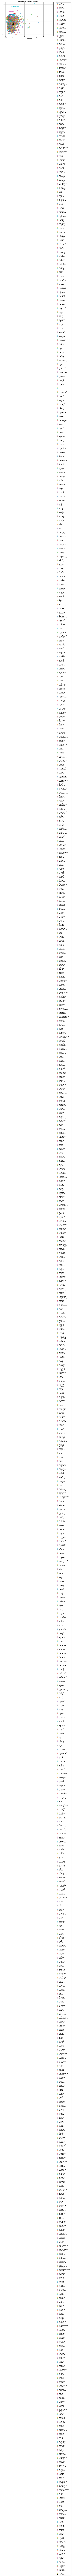

Recommended city: shaker heights,oh


In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Reset dataframe
merged_df = merged_df2.copy()

# Select features for clustering
feature_cols = ['Bedroom', 'Bathroom', 'Area', 'LotArea', 'Price', '2022 Median Income', 'Temperature', 'Population']
quality_cols = ['AQI%Good', 'WaterQualityVPV', 'Unemployment', '2016 Crime Rate', 'Cost of Living']
# Note: Curious about whether or not we should have Cost of Living be an inputted feature variable or if it should just be something that's generally minimized

# Preprocess: scale the features
scaler = StandardScaler()
X = scaler.fit_transform(merged_df[feature_cols])
# X = merged_df[feature_cols].values

# Get unique cities and map them
cities = merged_df['City'].unique()
city_to_index = {city: idx for idx, city in enumerate(cities)}
index_to_city = {idx: city for city, idx in city_to_index.items()}

# Assign city labels
y = merged_df['City'].map(city_to_index)

# Reduce dimensions for visualization
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

def recommend_city(user_input, visualize=True):
    # user_input: includes Bedroom, Bathroom, Area, LotArea, Price, Temperature, 2022 Median Income, Population
    temp_mapping = {'Cold': 0, 'Medium': 1, 'Hot': 2}
    
    user_features = np.array([
        user_input['Bedroom'],
        user_input['Bathroom'],
        user_input['Area'],
        user_input['LotArea'],
        user_input['Price'],
        user_input['2022 Median Income'],
        temp_mapping[user_input['Temperature']],  # map temp string to number
        user_input['Population']
    ]).reshape(1, -1)

    user_features_scaled = scaler.transform(user_features)

    # Calculate Euclidean distances
    distances = np.linalg.norm(X - user_features_scaled, axis=1)

    # Find k nearest neighbors
    k = 5
    top_k_indices = np.argsort(distances)[:k]

    # Look up corresponding cities
    neighbor_cities = y.iloc[top_k_indices].values

    # Tally up most common city
    unique, counts = np.unique(neighbor_cities, return_counts=True)
    candidate_cities = [index_to_city[idx] for idx in unique]

    # Filter original df for these candidates
    candidates_df = merged_df[merged_df['City'].isin(candidate_cities)].copy()

    # Score candidates based on quality metrics (Increasing or decreasing distance based on QoL features)
    candidates_df['QualityScore'] = (
        candidates_df['AQI%Good'] + candidates_df['WaterQualityVPV']
        - candidates_df['Unemployment'] * 2 - candidates_df['2016 Crime Rate'] * 2
        - candidates_df['Cost of Living'] * 1.5
    )

    # Group by city and take the best average score
    city_scores = candidates_df.groupby('City')['QualityScore'].mean()

    # Best city
    best_city = city_scores.idxmax()

    visualize = True
    if visualize:
        # Visualize
        user_2d = pca.transform(user_features_scaled)

        plt.figure(figsize=(10, 7))
        sample_size = 5000
        if len(merged_df) > sample_size:
            sampled_indices = np.random.choice(len(merged_df), size=sample_size, replace=False)
            sampled_df = merged_df.iloc[sampled_indices]
            X_2d_sampled = X_2d[sampled_indices]
        else:
            sampled_df = merged_df
            X_2d_sampled = X_2d

        for city in sampled_df['City'].unique():
            mask = sampled_df['City'] == city
            plt.scatter(X_2d_sampled[mask, 0], X_2d_sampled[mask, 1], label=city, alpha=0.5)

        plt.scatter(user_2d[0, 0], user_2d[0, 1], color='black', marker='X', s=200, label='User Input')

        for idx in top_k_indices:
            plt.plot([user_2d[0, 0], X_2d[idx, 0]], [user_2d[0, 1], X_2d[idx, 1]], 'k--', alpha=0.7)

        plt.title(f'Recommended City: {best_city}')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.xlabel('PCA Component 1')
        plt.ylabel('PCA Component 2')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return best_city

# Example user input
user_input = {
    'Bedroom': 4,
    'Bathroom': 4,
    'Area': 1500,
    'LotArea': 5000,
    'Price': 100000,
    '2022 Median Income': 70000,
    'Temperature': 'Medium',   # Now passed as text
    'Population': 150000     # New: user estimates size of city they want
}

best_city = recommend_city(user_input, visualize=True)
print(f"Recommended city: {best_city}")

# STEP 3: TESTING ACCURACY

Note: This first trial tests the accuracy of the features for each row in the testing data returning the specific city that is actually assigned to them. Since our model does not take in quality of life features as inputted Features, but instead tries to pick a city that generally minimizes or maximizes them (depending on the specific QoL feature) by default, this will return a relatively low accuracy since certain cities will have lower quality of life ratings and so will not be returned by the Model.

In [19]:
from sklearn.model_selection import train_test_split

# Split data (assuming Temperature is already part of X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

# Important: fix randomness
np.random.seed(42)

# Sample 500 test points
sample_size = 500
sample_indices = np.random.choice(len(X_test), size=sample_size, replace=False)

X_test_sampled = X_test[sample_indices]        # numpy array indexing
y_test_sampled = y_test.iloc[sample_indices]   # pandas Series positional indexing

# Recommendation function — no temperature penalty needed
def recommend_city_from_train(user_features_scaled, X_train, y_train, k=5):
    distances = np.linalg.norm(X_train - user_features_scaled, axis=1)
    
    top_k_indices = np.argsort(distances)[:k]
    neighbor_cities = y_train.iloc[top_k_indices].values
    unique, counts = np.unique(neighbor_cities, return_counts=True)
    best_city_idx = unique[np.argmax(counts)]
    return best_city_idx

# Evaluate accuracy on the sampled test set
correct = 0
total = len(X_test_sampled)

for i in range(total):
    user_features_scaled = X_test_sampled[i].reshape(1, -1)  # numpy indexing
    predicted_idx = recommend_city_from_train(user_features_scaled, X_train, y_train)
    actual_idx = y_test_sampled.iloc[i]  # pandas indexing

    if predicted_idx == actual_idx:
        correct += 1

accuracy = correct / total
print(f"Sampled model accuracy (on {sample_size} points): {accuracy:.2f}")

Sampled model accuracy (on 500 points): 0.70


# STEP 4: TESTING ACCURACY WITHOUT SIMPLY MAXIMIZING QUALITY OF LIFE FEATURES

Now, we tinker with constructing our model to recieve QoL features as input, so that we can see how good it is at generally predicting data. If this model can return a high accuracy, we know our KNN Algorithm is working properly to at least predict the cities accurately. However, for the final model, we will change it back to maximizing or minimizing certain QoL values because we are not just trying to predict a city but are trying to give the user the best option.

In [20]:
from sklearn.model_selection import train_test_split

# Reset dataframe
merged_df = merged_df2.copy()

# Step 1: Prepare feature set that includes quality of life features + temperature + population
full_feature_cols = ['Bedroom', 'Bathroom', 'Area', 'LotArea', 'Price', '2022 Median Income',
                     'AQI%Good', 'WaterQualityVPV', 'Unemployment', '2016 Crime Rate', 'Cost of Living', 
                     'Temperature', 'Population'] 

# Preprocess: scale the full features
scaler_full = StandardScaler()
X_full = scaler_full.fit_transform(merged_df[full_feature_cols])
# X_full = merged_df[full_feature_cols].values

# Labels stay the same
y_full = merged_df['City'].map(city_to_index)

# Step 2: Train/test split
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_full, y_full, test_size=0.05, random_state=42)

# Important: fix randomness
np.random.seed(42)

# Optional: sample 500 points to keep speed reasonable
sample_size = 500
sample_indices = np.random.choice(len(X_test_full), size=sample_size, replace=False)
X_test_sampled_full = X_test_full[sample_indices]
y_test_sampled_full = y_test_full.iloc[sample_indices]

# Step 3: Define a pure recommend function
def pure_recommend_city(user_features_scaled, X_train, y_train, k=5):
    distances = np.linalg.norm(X_train - user_features_scaled, axis=1)

    top_k_indices = np.argsort(distances)[:k]
    neighbor_cities = y_train.iloc[top_k_indices].values
    unique, counts = np.unique(neighbor_cities, return_counts=True)
    best_city_idx = unique[np.argmax(counts)]
    return best_city_idx

# Step 4: Evaluate pure matching accuracy
correct = 0
total = len(X_test_sampled_full)

for i in range(total):
    user_features_scaled = X_test_sampled_full[i].reshape(1, -1)
    predicted_idx = pure_recommend_city(user_features_scaled, X_train_full, y_train_full)
    actual_idx = y_test_sampled_full.iloc[i]

    if predicted_idx == actual_idx:
        correct += 1

pure_accuracy = correct / total
print(f"Pure Matching Model Accuracy: {pure_accuracy:.2f}")

Pure Matching Model Accuracy: 0.85


# STEP 5: TUNING MODEL PARAMETERS AND SCALARS TO MAXIMIZE ACCURACY

- Now, we try to tune the model for higher accuracy by increasing the weights of important, city-defining features, dropping noisy features, increasing the value of k, and other tweaks

- Once we find the modifications that maximize the model's accuracy without QoL optimization, we can re-implement these tweaks into the regular model which DOES maximize QoL Values, as we know that these results will be more accurate to the user's inputs while still maximizing better quality of life.

In [21]:
from sklearn.model_selection import train_test_split

# Reset dataframe
merged_df = merged_df2.copy()

# Step 1: Prepare feature set that includes quality of life features + temperature + population
full_feature_cols = ['Bedroom', 'Bathroom', 'Area', 'LotArea', 'Price', '2022 Median Income',
                     'AQI%Good', 'WaterQualityVPV', 'Unemployment', '2016 Crime Rate', 'Cost of Living', 
                     'Temperature', 'Population']

# merged_df["2022 Median Income"] *= 1
# merged_df["Cost of Living"] *= 2.5
# merged_df["Population"] *= 2
# merged_df["Temperature"] *= 2.5 
#merged_df['Bedroom'] *= 1.5
#merged_df['Bathroom'] *= 1.5
#merged_df['Area'] *= 5
# merged_df['LotArea'] *= 1.5

# Preprocess: scale the full features
scaler_full = StandardScaler()
X_full = scaler_full.fit_transform(merged_df[full_feature_cols])
# X_full = merged_df[full_feature_cols].values

# Weigh features to prioritize more important, impactful ones
# feature_weights = np.array([1, 1, 1, 1, 1, 2.5, 1, 1, 1, 1, 2, 3, 2])
feature_weights = np.array([1, 1, 1, 1.5, 1, 4, 1, 1, 1, 1, 2.5, 3, 3])


# Labels stay the same
y_full = merged_df['City'].map(city_to_index)

# Step 2: Train/test split
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_full, y_full, test_size=0.05, random_state=42)

# Important: fix randomness
np.random.seed(42)

# Optional: sample 500 points to keep speed reasonable
sample_size = 500
sample_indices = np.random.choice(len(X_test_full), size=sample_size, replace=False)
X_test_sampled_full = X_test_full[sample_indices]
y_test_sampled_full = y_test_full.iloc[sample_indices]

# Step 3: Define a pure recommend function (NO temperature penalty anymore)
def pure_recommend_city(user_features_scaled, X_train, y_train, k=5):
    weighted_diff = (X_train - user_features_scaled) * feature_weights
    distances = np.linalg.norm(weighted_diff, axis=1)

    top_k_indices = np.argsort(distances)[:k]
    neighbor_cities = y_train.iloc[top_k_indices].values
    unique, counts = np.unique(neighbor_cities, return_counts=True)
    best_city_idx = unique[np.argmax(counts)]
    return best_city_idx

# Step 4: Evaluate pure matching accuracy
correct = 0
total = len(X_test_sampled_full)

for i in range(total):
    user_features_scaled = X_test_sampled_full[i].reshape(1, -1)
    predicted_idx = pure_recommend_city(user_features_scaled, X_train_full, y_train_full)
    actual_idx = y_test_sampled_full.iloc[i]

    if predicted_idx == actual_idx:
        correct += 1

pure_accuracy = correct / total
print(f"Pure Matching Tuned Model Accuracy: {pure_accuracy:.2f}")

Pure Matching Tuned Model Accuracy: 0.90


# STEP 6: RECONSTRUCTING A MORE ACCURATE KNN

- Now, we reconstruct the KNN with these modifications to get our final, most accurate KNN which prioritizes Quality of Life values

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Reset dataframe
merged_df = merged_df2.copy()

# Select features for clustering
feature_cols = ['Bedroom', 'Bathroom', 'Area', 'LotArea', 'Price', '2022 Median Income', 'Temperature', 'Population']
quality_cols = ['AQI%Good', 'WaterQualityVPV', 'Unemployment', '2016 Crime Rate', 'Cost of Living']
# Note: Curious about whether or not we should have Cost of Living be an inputted feature variable or if it should just be something that's generally minimized

# Preprocess: scale the features
scaler = StandardScaler()
X = scaler.fit_transform(merged_df[feature_cols])
# X = merged_df[feature_cols].values

# Weigh features to prioritize more important, impactful ones
feature_weights = np.array([1, 1, 1, 1.5, 1, 4, 3, 3])

# Get unique cities and map them
cities = merged_df['City'].unique()
city_to_index = {city: idx for idx, city in enumerate(cities)}
index_to_city = {idx: city for city, idx in city_to_index.items()}

# Assign city labels
y = merged_df['City'].map(city_to_index)

# Reduce dimensions for visualization
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

def recommend_city(user_input, visualize=True):
    # user_input: includes Bedroom, Bathroom, Area, LotArea, Price, Temperature, 2022 Median Income, Population
    temp_mapping = {'Cold': 0, 'Medium': 1, 'Hot': 2}
    
    user_features = np.array([
        user_input['Bedroom'],
        user_input['Bathroom'],
        user_input['Area'],
        user_input['LotArea'],
        user_input['Price'],
        user_input['2022 Median Income'],
        temp_mapping[user_input['Temperature']],  # map temp string to number
        user_input['Population']
    ]).reshape(1, -1)

    user_features_scaled = scaler.transform(user_features)

    # Calculate Euclidean distances
    weighted_diff = (X_train - user_features_scaled) * feature_weights
    distances = np.linalg.norm(weighted_diff, axis=1)

    # Find k nearest neighbors
    k = 5
    top_k_indices = np.argsort(distances)[:k]

    # Look up corresponding cities
    neighbor_cities = y.iloc[top_k_indices].values

    # Tally up most common city
    unique, counts = np.unique(neighbor_cities, return_counts=True)
    candidate_cities = [index_to_city[idx] for idx in unique]

    # Filter original df for these candidates
    candidates_df = merged_df[merged_df['City'].isin(candidate_cities)].copy()

    # Score candidates based on quality metrics (Increasing or decreasing distance based on QoL features)
    candidates_df['QualityScore'] = (
        candidates_df['AQI%Good'] + candidates_df['WaterQualityVPV']
        - candidates_df['Unemployment'] * 2
        - candidates_df['2016 Crime Rate'] * 2
        - candidates_df['Cost of Living'] * 1.5
    )

    # Group by city and take the best average score
    city_scores = candidates_df.groupby('City')['QualityScore'].mean()

    # Best city
    best_city = city_scores.idxmax()

    visualize = False
    if visualize:
        # Visualize
        user_2d = pca.transform(user_features_scaled)

        plt.figure(figsize=(10, 7))
        sample_size = 5000
        if len(merged_df) > sample_size:
            sampled_indices = np.random.choice(len(merged_df), size=sample_size, replace=False)
            sampled_df = merged_df.iloc[sampled_indices]
            X_2d_sampled = X_2d[sampled_indices]
        else:
            sampled_df = merged_df
            X_2d_sampled = X_2d

        for city in sampled_df['City'].unique():
            mask = sampled_df['City'] == city
            plt.scatter(X_2d_sampled[mask, 0], X_2d_sampled[mask, 1], label=city, alpha=0.5)

        plt.scatter(user_2d[0, 0], user_2d[0, 1], color='black', marker='X', s=200, label='User Input')

        for idx in top_k_indices:
            plt.plot([user_2d[0, 0], X_2d[idx, 0]], [user_2d[0, 1], X_2d[idx, 1]], 'k--', alpha=0.7)

        plt.title(f'Recommended City: {best_city}')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.xlabel('PCA Component 1')
        plt.ylabel('PCA Component 2')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return best_city

# Example user input
user_input = {
    'Bedroom': 3,
    'Bathroom': 2,
    'Area': 2500,
    'LotArea': 5000,
    'Price': 1000000,
    '2022 Median Income': 160000,
    'Temperature': 'Cold',   # Now passed as text
    'Population': 500000     # New: user estimates size of city they want
}

best_city = recommend_city(user_input, visualize=True)
print(f"Recommended city: {best_city}")

Recommended city: orlando,fl


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


# STEP 7: CREATING A KNN FOR EVERY POSSIBLE COMBINATION OF USER INPUTTED FEATURES

## INFO FOR MIDWAY REPORT:

- Essentially what we're gonna do here is, after deciding which features we want to make Mandatory for the user to input, we will create a model for each different combination of user inputted features, so that the result that our entire machine/program gives them is accurate to what they inputted. For example, if they only specified temperature, price, and square footage, we should give them their best city based only on those fields, rather than simply choosing a default value for their unfilled fields and running that on our first model. This would greatly limit the possible outcomes of the model to be cities that match the default fields we would select for when a user leaves something blank. So we're not gonna do this. We probably want less than 30 or 40 models, cuz otherwise it gets redundant, so maybe we'll only leave 5 or 6 features optional.

- This is imporant because this specific implementation is how we are overcoming the problem of a MODEL RUNNING WHEN INPUT FEATURES ARE MISSING, which is a large part of our project and is one of the main questions we sought to answer. We also were interested in removing outliers, which we could propose involves modifying the data to look at things like the average house size/num bedrooms found in a city, etc, because there may be outliers in each city that are massively large mansions even though the city is generally poor. So the solution would be essentially changing the data to represent averages and medians across cities, specifically when it involves the house-features (since the city features are already the same for all house entries which are in the same city, since we filled out the city-related columns just based off of the city that the house was in). This is something we can suggest we will look more into going forward.

- Finally, we should also talk about what else we do to expand past KNNs, since we are almost entirely done with the KNNs. We have already proposed that we look into other types of models that could essentially create the same tool we're trying to build based off of our data, and then investigate how to deal with missing features as well as outliers in both of then. I think that we should say we're interested in doing a Linear Regression model, as well as trying random forest. I think Linear Regression would be stronger to have on our Midway report, even if we're not gonna do it. I also think we should say we're interested in trying a neural network.

- OOH - BOOM. I THINK I GOT IT. WE SHOULD SAY THAT, ONCE WE MAKE A FEW MODELS WHICH DO THE SAME THING, USING DIFFERENT ML TACTICS, WE SHOULD PLAN TO COMPARE THEM BY SEEING WHAT DIFFERENT CITIES THEY COME UP WITH WHEN GIVEN THE SAME INPUT AFTER BEING TRAINED ON THE SAME DATA. THIS WOULD BE REALLY INTERESTING, BECAUSE THEN WE COULD CREATE A SIMPLE TESTING ALGORITHM WHICH FINDS OUT WHICH MODEL GAVE A CITY MORE ACCURATE TO THE USER'S PREFERENCES. THEN WE CAN THEORIZE WHY ONE IS BETTER THAN THE OTHER, AND BOOM THAT'S A GOOD PROJECT.

- Also, in the midway report, make sure to specify how we've divided our data into input features from the user and just general QoL features that the model either tries to maximize or minimize in the cities it outputs, regardless of the user inputted data. This feature makes our approach a bit more unique compared to just any other KNN or ML model which provides a predicted output based on features. Otherwisem, just look through all the comments and headers in this document and try to summarize what has been done. This document pretty much contains everything that has been done for the project LMAO.

- For the literature section, we need to do more work (Adhi was also right during that meeting, we essentially do have to BS it since most of my info has come from chatgpt), so we need to find some resources that we can pretend we got inspiration and insight from in terms of coding our project. I used freecodecamp a bit to learn about this stuff, so i can add that in.

- Dividing up the work section should just be like one sentence, and our future plans should involve what i already specified here pretty much.